In [384]:
import utils

import vision_transformer_3d_test as vits
from vision_transformer_3d_test import CLSHead, RECHead_3D
import torchvision

import torch.nn as nn
import torch

import csv

import numpy as np

In [385]:
utils.fix_random_seeds(0)

## Load Models

In [386]:
class FullPipline(nn.Module):
    def __init__(self, backbone, head, head_recons):
        super(FullPipline, self).__init__()
        
        backbone.fc, backbone.head = nn.Identity(), nn.Identity()
        self.backbone = backbone
        self.head = head
        self.head_recons = head_recons

    def forward(self, x, recons=True):
        _out = self.backbone(x)
        
        if recons:
            return self.head(_out[:, 0]), self.head_recons(_out[:, 1:])
        else:
            return self.head(_out[:, 0]), None

    def extract_features(self, x):
        return self.backbone(x)

In [479]:
student = vits.__dict__["vit_base"](drop_path_rate=0.1)
teacher = vits.__dict__["vit_base"]()

In [480]:
student = FullPipline(student, CLSHead(768, 256), RECHead_3D(768))
teacher = FullPipline(teacher, CLSHead(768, 256), RECHead_3D(768))

In [481]:
def remove_module_prefix(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('module.'):
            new_key = key[len('module.'):]
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

In [482]:
checkpoint = torch.load("../checkpoints/checkpoint0100.pth", map_location="cpu")

In [483]:
checkpoint['teacher'] = remove_module_prefix(checkpoint['teacher'])
checkpoint['student'] = remove_module_prefix(checkpoint['student'])

In [484]:
# Load the state dict from the checkpoint
teacher.load_state_dict(checkpoint['teacher'])
student.load_state_dict(checkpoint['student'])

<All keys matched successfully>

## Load Dataset

In [393]:
from datasets import datasets_utils_test
from datasets.load_dataset_test import NumpyArrayDataset

import argparse
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np

In [394]:
# replace from other images
class collate_batch(object): 
    def __init__(self, drop_replace=0.3, drop_align=(1,1,1)):
        self.drop_replace = drop_replace
        self.drop_align = drop_align
        
    def __call__(self, batch):
        batch = torch.utils.data.dataloader.default_collate(batch)
        
        if self.drop_replace > 0:
            batch[1][0], batch[2][0] = datasets_utils_test.GMML_replace_list(batch[0][0], batch[1][0], batch[2][0],
                                                                            max_replace=self.drop_replace, align=self.drop_align)
            batch[1][1], batch[2][1] = datasets_utils_test.GMML_replace_list(batch[0][1], batch[1][1], batch[2][1],
                                                                            max_replace=self.drop_replace, align=self.drop_align)
        
        return batch

In [395]:
args = argparse.Namespace(drop_perc=0.5, drop_replace=0.3, drop_type='zeros', data_location='../npz/original/',
                          batch_size = 16, drop_align=(1,1,1), volume_size=(21, 64, 64))
transform = datasets_utils_test.DataAugmentationSiT(args)

In [396]:
# Create an instance of custom dataset
dataset = NumpyArrayDataset(args.data_location, transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset,
    #sampler=sampler, 
    batch_size=args.batch_size,
    #num_workers=args.num_workers, 
    pin_memory=True, 
    drop_last=True, 
    collate_fn=collate_batch(args.drop_replace, args.drop_align),
    shuffle=True)

---

## Visualization

In [397]:
import matplotlib.pyplot as plt

def plot_one_slice(img, cmap = 'gray'):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [398]:
clean_crops, corrupted_crops, masks_crops = next(iter(data_loader))

In [399]:
clean_crops[0].shape

torch.Size([16, 1, 21, 64, 64])

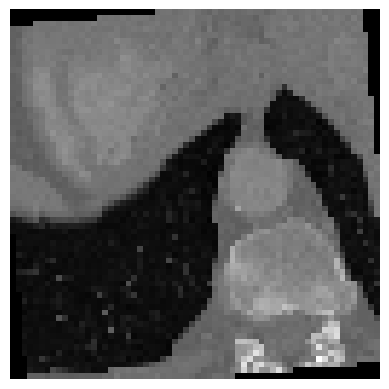

In [446]:
plot_one_slice(clean_crops[0][7][0][10].numpy())

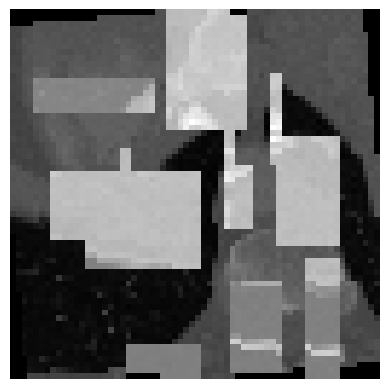

In [450]:
plot_one_slice(corrupted_crops[0][7][0][10].numpy())

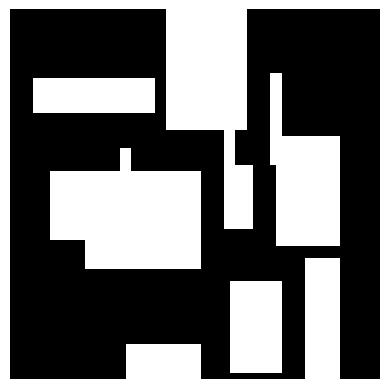

In [451]:
plot_one_slice(masks_crops[0][7][0][10].numpy())

In [485]:
s_cls, s_recons = student(torch.cat(corrupted_crops[0:]), recons=True)

In [486]:
s_recons.shape

torch.Size([32, 1, 21, 64, 64])

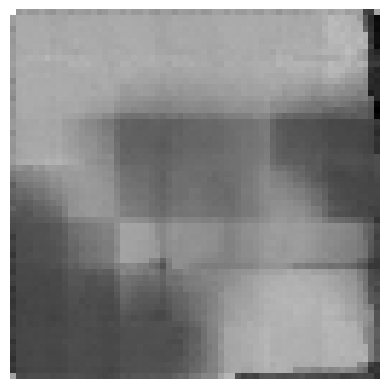

In [487]:
plot_one_slice(s_recons[7][0][10].detach().numpy())

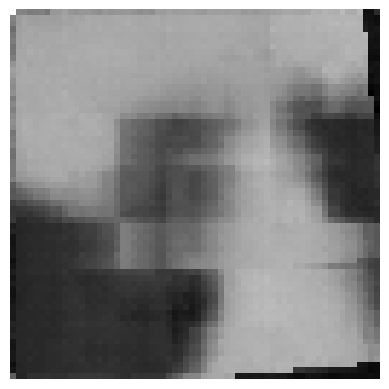

In [478]:
plot_one_slice(s_recons[7][0][10].detach().numpy())

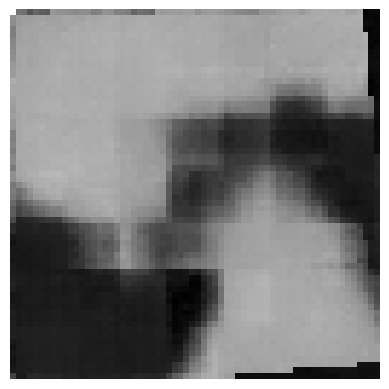

In [469]:
plot_one_slice(s_recons[7][0][10].detach().numpy())

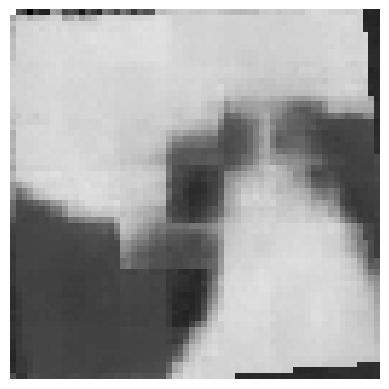

In [460]:
plot_one_slice(s_recons[7][0][10].detach().numpy())

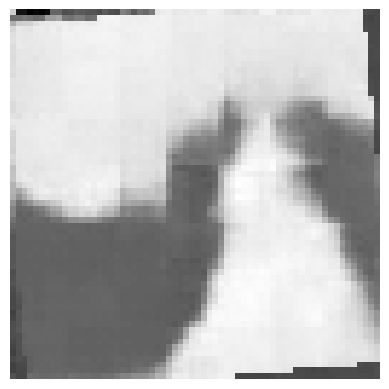

In [448]:
plot_one_slice(s_recons[7][0][10].detach().numpy())

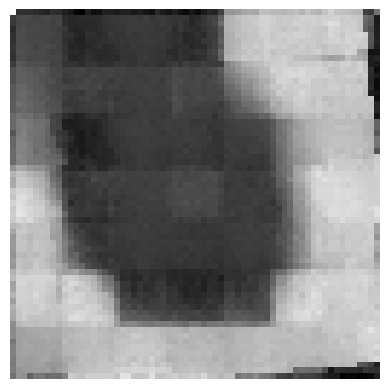

In [369]:
plot_one_slice(s_recons[0][0][9].detach().numpy())

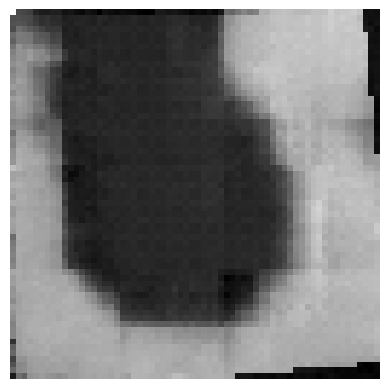

In [363]:
plot_one_slice(s_recons[0][0][9].detach().numpy())

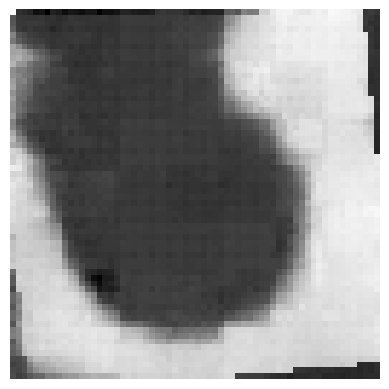

In [357]:
plot_one_slice(s_recons[0][0][9].detach().numpy())

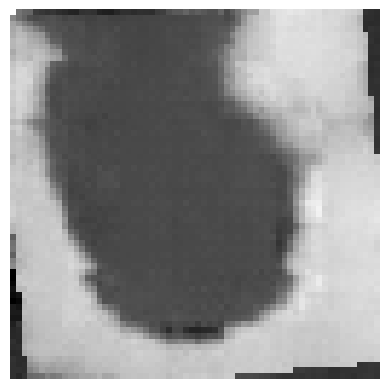

In [351]:
plot_one_slice(s_recons[0][0][9].detach().numpy())

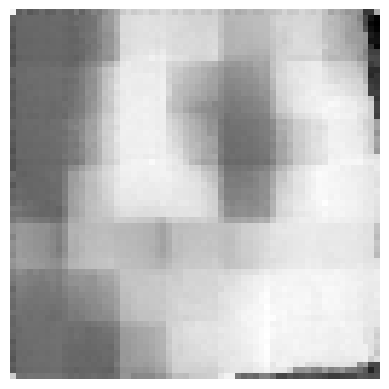

In [271]:
plot_one_slice(s_recons[9][0][10].detach().numpy())